# Lattice

In [72]:
from manim import Scene, config, Axes # General Stuff

from manim import Dot, Arrow, MathTex # Objects
from manim import WHITE, BLACK, GRAY, GREEN, RED # Colors
from manim import RIGHT, LEFT, DOWN, UP
config["background_color"] = WHITE
import numpy as np

basis = np.asarray([
    [1,1.5],
    [1, 0]
])

points = []
for q in range(-10, 10, 1):
    for j in range(-10, 10, 1):
        points.append(np.asarray([q, j]))

lattice_points = [basis @ p for p in points]

class LatticeGrid(Scene):

    def construct(self):
        ax = Axes(x_range=[-7, 7, 1],
                  y_range=[-7, 7, 1],
                  x_length=15,
                  y_length=15,
                  axis_config={
                      "stroke_color": GRAY,
                      "tick_size": 0
                  },
                  tips=False)

        dots = [
            Dot(ax.coords_to_point(p[0], p[1]), color=BLACK, radius=0.08)
            for p in lattice_points
        ]

        b1 = Arrow(ax.coords_to_point(0, 0),
                   ax.coords_to_point(*basis @ np.asarray([1, 0])),
                   color=GREEN,
                   buff=0)
        b1_text = MathTex(r"b_1", color=GREEN).next_to(b1, UP)
        b2 = Arrow(ax.coords_to_point(0, 0),
                   ax.coords_to_point(*basis @ np.asarray([0, 1])),
                   color=RED,
                   buff=0)
        b2_text = MathTex(r"b_2", color=RED).next_to(b2, RIGHT)

        self.add(ax, *dots, b1, b2, b1_text, b2_text)




In [30]:
%manim -qm -v WARNING -r 1000,1000 LatticeGrid

ManimColor('#000000')

# Output Size

In [6]:
from itertools import product
from math import ceil

import pandas as pd
import seaborn as sns

from dataclasses import dataclass
from timeit import timeit

from ModuleBfv import BFV, BfvConfig
from random import randint
from tqdm import tqdm

from operator import add, mul
from typing import Callable
from ModuleBfv import get_error
from Polynomial import RingPoly
import multiprocessing as mp

from itertools import chain
from matplotlib import pyplot as plt

In [3]:
def sk(n: int, d: int, **kwargs) -> int:
    return n * d

def pk(n: int, d: int, **kwargs) -> int:
    return (n*n+n) * d

def rlk(n: int, d: int, **kwargs) -> int:
    return n*((n*n+n) * d)

def m(n: int, d: int, l:int, **kwargs) -> int:
    return ceil(l/d) * d

def ct(n: int, d: int, l:int, **kwargs) -> int:
    return ceil(l/d) * ((n+1) * d)


In [4]:
plwe = "Plain-LWE"
rlwe = "Ring-LWE"
mlwe = "Module-LWE"
schemes = [plwe, rlwe, mlwe]
functions = [sk, pk ,rlk, m, ct]
DataContainer = []

for function, scheme in product(functions, schemes):
    d_range = [1] if scheme == plwe else range(0, 257, 2)
    n_range = [1] if scheme == rlwe else range(0, 257, 2)
    for n in n_range:
        if n==0:
            n = 1
        for d in d_range:
            if d == 0:
                d= 1
            DataContainer.append({
                "scheme": scheme,
                "function": function.__name__,
                "n": n,
                "d": d,
                "l": 64,
                "bit": function(n=n, d=d, l=64)
            })
dn_df = pd.DataFrame(DataContainer)

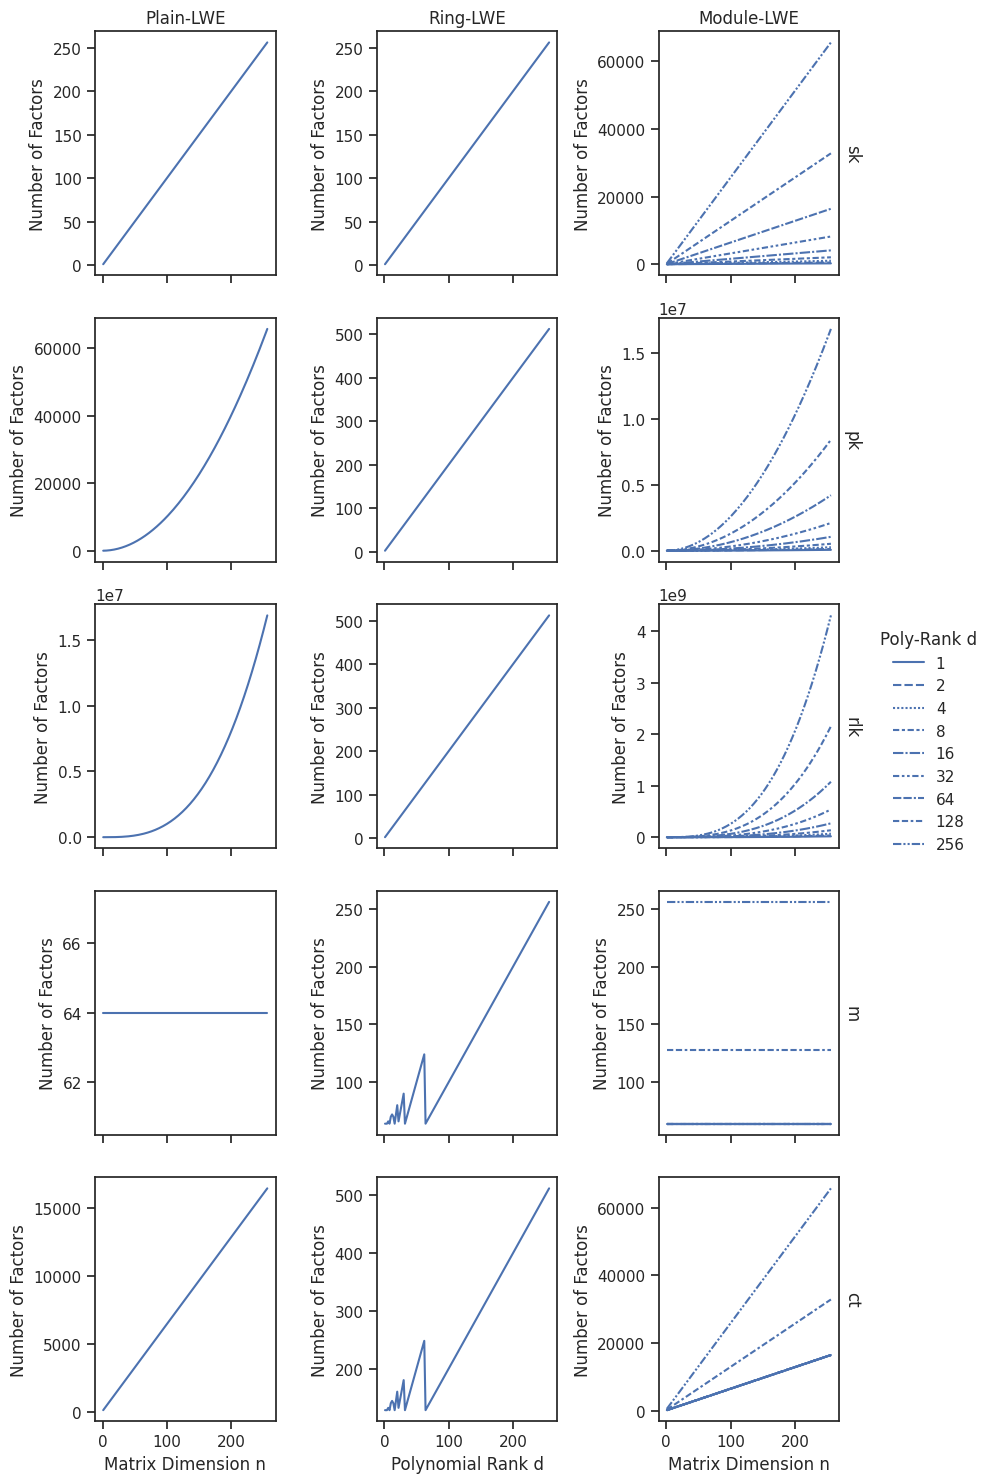

In [5]:
sns.set_theme(style="ticks")

grid = sns.FacetGrid(dn_df, col="scheme", row="function",
                     margin_titles=True, despine=False, sharey=False, legend_out=True, sharex="col")
grid.set_titles(col_template="{col_name}", row_template="{row_name}")
grid.set_ylabels("number of factors")

vals = [2**i for i in range(9)]
def plot(data: pd.DataFrame, color, **kwargs):
    # print(kwargs)
    if data["scheme"].unique()[0] == rlwe:
        p = sns.lineplot(data, x="d", y="bit",
                         color=color)
        p.set_xlabel("Polynomial Rank d")
    elif data["scheme"].unique()[0] == plwe:
        p = sns.lineplot(data, x="n", y="bit", color=color)
        p.set_xlabel(
            "Matrix Dimension n")
    else:
        data = data.loc[data.d.isin(vals)]
        p = sns.lineplot(data, x="n", y="bit", style="d", color=color,
                         legend="full")
        p.set_xlabel("Matrix Dimension n")
    p.set_ylabel("Number of Factors")


grid.map_dataframe(plot)
grid.add_legend(title='Poly-Rank d')

# Performance Test

In [16]:
@dataclass
class DataContainer:
    method: str
    n: int
    d: int
    q: int
    p: int
    time: float


rounds = 10

def compute(x):
    n, d, q, p = x
    if n== 0:
        n = 1
    if d == 0:
        d= 1
    data = []
    conf = BfvConfig(n, d, 2**q, 2**(q*p))
    t_kg = timeit(lambda: BFV.keygen(conf), number=rounds) / rounds
    data.append(DataContainer("KeyGen", n, d, q, p, t_kg))

    sk, pk, rlk = BFV.keygen(conf)
    m = [randint(0, 1) for _ in range(0, d)]
    t_enc = timeit(lambda: BFV.encrypt(
        conf, pk, rlk, m), number=rounds) / rounds
    data.append(DataContainer("Encryption", n, d, q, p, t_enc))

    ct = BFV.encrypt(conf, pk, rlk, m)
    t_dec = timeit(lambda: BFV.decrypt(sk, ct), number=rounds) / rounds
    data.append(DataContainer("Decrypt", n, d, q, p, t_dec))

    t_add = timeit(lambda: ct+ct, number=rounds) / rounds
    data.append(DataContainer("Addition", n, d, q, p, t_add))

    t_mul = timeit(lambda: ct*ct, number=rounds) / rounds
    data.append(DataContainer("Multiplication", n, d, q, p, t_mul))

    return data

# parameters = list(product(range(0, 33, 2), range(0, 33, 2), [32], [3]))*4
# with mp.Pool(mp.cpu_count()) as pool:
#     dn_res = list(tqdm(pool.imap_unordered(compute, reversed(parameters)), total=len(parameters)))
# parameters = list(product([10], [10], range(4, 81, 4), range(1, 11)))*20
# with mp.Pool(mp.cpu_count()) as pool:
#     qp_res = list(tqdm(pool.imap_unordered(compute, reversed(parameters)), total=len(parameters)))
parameters = ([1, 512, 15, 3], [3, 256, 13, 3])*20
with mp.Pool(mp.cpu_count()) as pool:
    alg_res = list(tqdm(pool.imap_unordered(compute, reversed(parameters)), total=len(parameters)))

100%|██████████| 40/40 [00:54<00:00,  1.36s/it]


In [17]:
# dn_df = pd.DataFrame(chain(*dn_res))
# dn_df.to_csv("dn_performance.csv")
# qp_df = pd.DataFrame(chain(*qp_res))
# qp_df.to_csv("qp_performance.csv")
alg_df = pd.DataFrame(chain(*alg_res))
# qp_df.to_csv("qp_performance.csv")

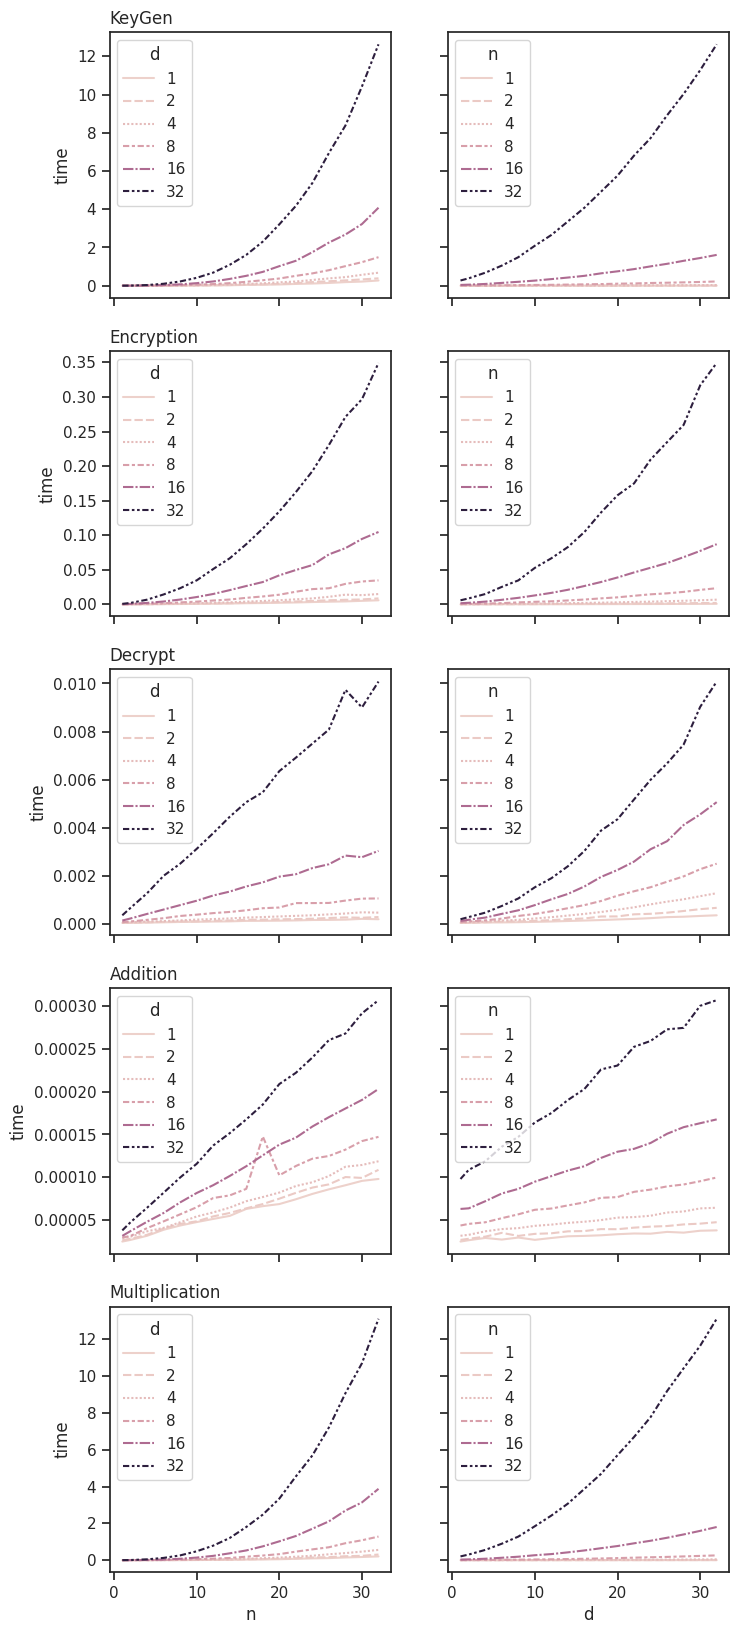

In [49]:



sns.set_theme(style="ticks")
rows = dn_df["method"].unique()
fig, axs = plt.subplots(ncols=2, nrows=len(rows), figsize=(8,4*len(rows)), sharex="all", sharey="row")
vals = [2**i for i in range(7)]
for row, method in zip(axs, rows):
    sub_df = dn_df.loc[dn_df["method"] == method].drop(columns=["method"]).groupby(["n", "d", "p", "q"]).median().reset_index()
    row[0].set_title(method, loc="left")
    sns.lineplot(sub_df.loc[sub_df.d.isin(vals)], x="n", y="time", ax=row[0], style="d", hue="d")
    sns.lineplot(sub_df.loc[sub_df.n.isin(vals)], x="d", y="time", ax=row[1], style="n", hue="n")

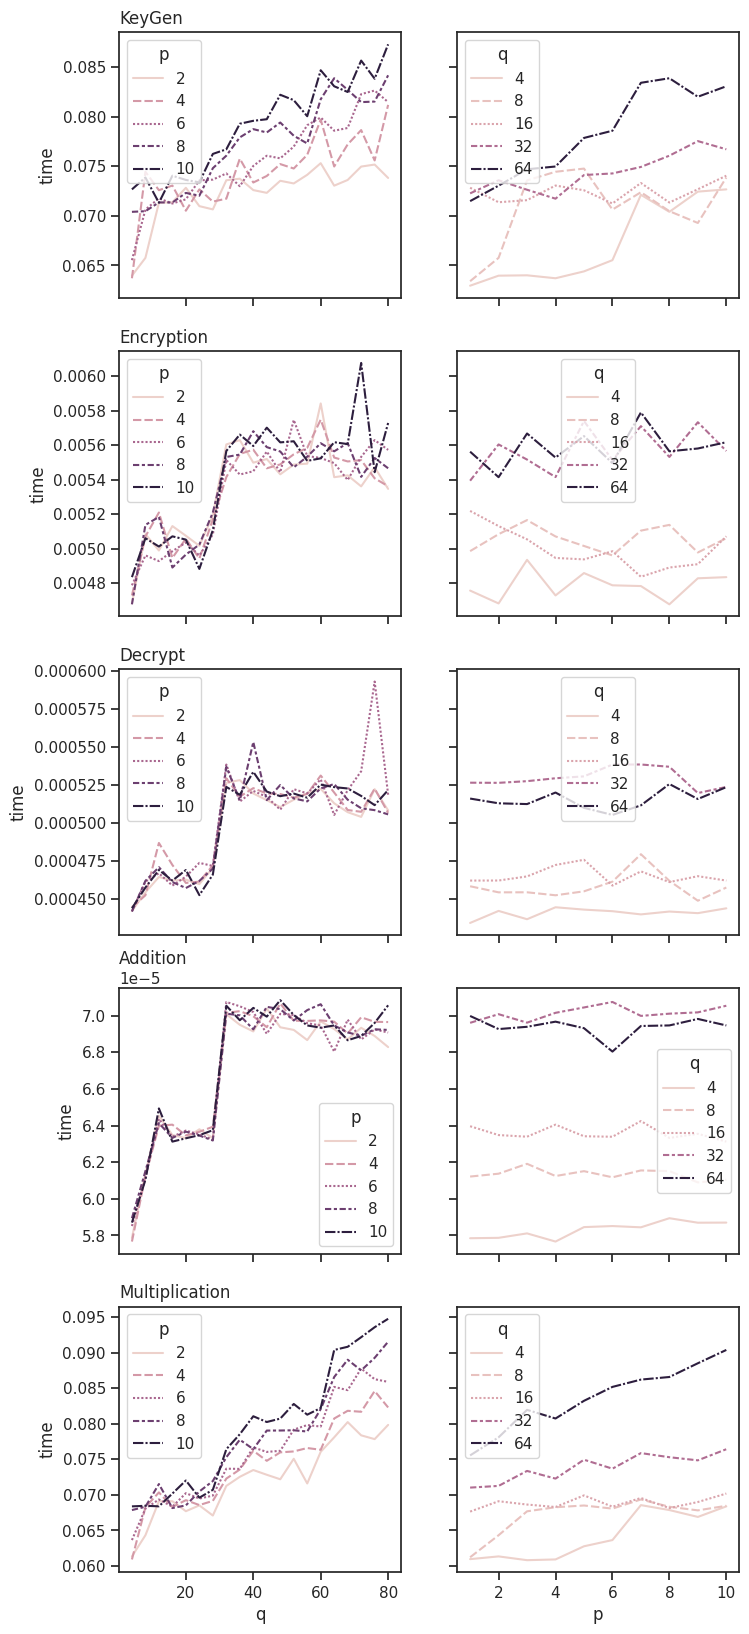

In [10]:
sns.set_theme(style="ticks")
rows = qp_df["method"].unique()
fig, axs = plt.subplots(ncols=2, nrows=len(rows), figsize=(8,4*len(rows)), sharex="col", sharey="row")
vals = [2**i for i in range(7)]
for row, method in zip(axs, rows):
    sub_df = qp_df.loc[qp_df["method"] == method].drop(columns=["method"]).groupby(["n", "d", "p", "q"]).median().reset_index()
    row[0].set_title(method, loc="left")
    sns.lineplot(sub_df.loc[sub_df.p.isin([i*2 for i in range(7)])], x="q", y="time", ax=row[0], style="p", hue="p")
    sns.lineplot(sub_df.loc[sub_df.q.isin([2**i for i in range(7)])], x="p", y="time", ax=row[1], style="q", hue="q")

In [54]:
print(alg_df.groupby(["method", "n", "d", "p", "q"])
        .median()
        .reset_index()
        .assign(algorithm=lambda x: x.n.mask(lambda x: x==1, "R-LWE")
                                        .mask(lambda x: x==3, "M-LWE"))
        .sort_values("algorithm")
        .pivot_table(columns="method", aggfunc="first", index="algorithm", values="time")
        .to_latex()
) # yapf: disable


\begin{tabular}{lrrrrr}
\toprule
method & Addition & Decrypt & Encryption & KeyGen & Multiplication \\
algorithm &  &  &  &  &  \\
\midrule
M-LWE & 0.000176 & 0.041224 & 0.174293 & 0.696122 & 1.039662 \\
R-LWE & 0.000163 & 0.061521 & 0.125041 & 0.182526 & 0.473052 \\
\bottomrule
\end{tabular}



# Multiplicative and Additive Depth

In [97]:
@dataclass
class DataContainer:
    method: str
    n: int
    d: int
    q: int
    p: int
    depth: float
    error_dev: list[float]


data = []
rounds = 5

bfv = BFV()


def get_depth(operation: Callable, conf: BfvConfig, max_rounds=100):
    error_dev = []
    sk, pk, rlks = BFV.keygen(conf)
    m1 = RingPoly.random_ring_poly(conf.poly_len, 0, 1)
    m_e1 = BFV.encrypt(conf, pk, rlks, m1)
    for i in range(max_rounds):
        m2 = RingPoly.random_ring_poly(conf.poly_len, 0, 1)
        m_e2 = BFV.encrypt(conf, pk, rlks, m2)
        m_e1 = operation(m_e1, m_e2)
        m1 = operation(m1, m2) % 2
        # error_dev.append(get_error(m_e1, m1, sk))
        # assert BFV.decrypt(sk, m_e1) == m1.poly_mat[0].tolist(), f"{i}: {m1} -- {BFV.decrypt(sk, m_e1)}"
        if BFV.decrypt(sk, m_e1) != m1:
            break
    return i, error_dev


# parameters = list(product(range(0, 33, 2), repeat=2))
parameters = list(product(range(0, 5), range(0, 5), range(1, 65, 2)))
# run 20 rounds for each parameter set
parameters = parameters * 20
def compute(x):
    n, d, q = x
    p= 3
    n = 2**n
    d = 2**d
    conf = BfvConfig(n, d, 2**q, 2**(q*p))

    # depth, error = get_depth(add, conf)
    # data.append(DataContainer("Addition", n, d, q, p, depth, error))
    depth, error = get_depth(mul, conf)
    return DataContainer("Multiplication", n, d, q, p, depth, error)

with mp.Pool(mp.cpu_count()) as pool:
    dn_res = list(tqdm(pool.imap_unordered(compute, reversed(parameters)), total=len(parameters)))

100%|██████████| 16000/16000 [05:08<00:00, 51.89it/s] 


In [4]:
# df = pd.DataFrame(results)
# df.to_csv("depth_data.csv")
dn_df = pd.read_csv("depth_data.csv", index_col=0)

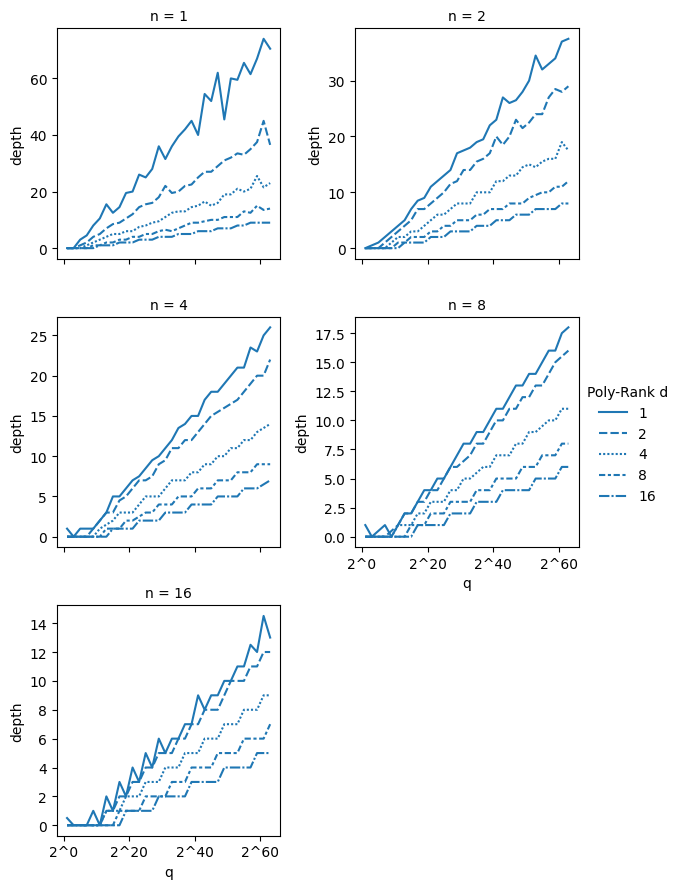

In [27]:
from matplotlib import ticker
from numpy import mean


grid = sns.FacetGrid(dn_df.drop(columns=["error_dev"]).groupby(["method", "n", "d", "q", "p"]).median().reset_index(), col="n", margin_titles=True,
                     despine=False, sharey=False, legend_out=True, sharex=True, col_wrap=2)


def plot(data: pd.DataFrame, color):
    p = sns.lineplot(data, x="q", y="depth", legend="full", estimator="median", style="d")
    # p.set(yscale="log")
    # p.set_xscale("log", base=2)
    # p.set_xlabel("Matrix Dimension n")
    # p.set_ylabel("Number of Factors")
    
    p.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:f"2^{int(x)}"))


grid.map_dataframe(plot)
grid.add_legend(title='Poly-Rank d')